In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
import sklearn
from sklearn.metrics import classification_report
from sklearn.datasets import make_circles, make_moons
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

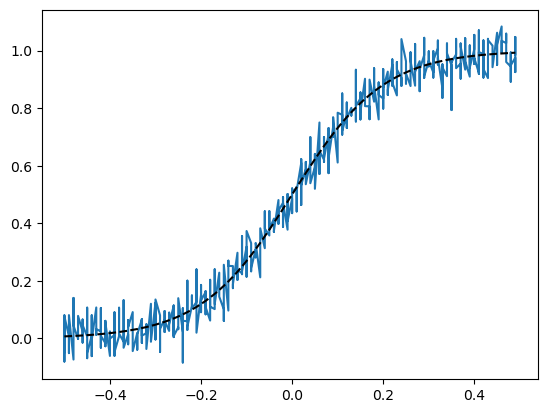

In [2]:
X = (np.arange(100)/100 - 0.5).repeat(5)

y = 1/(1+np.exp(-10*X))
yn = np.random.normal(scale=0.05, size=y.size)+y

plt.plot(X, yn)
plt.plot(X, y, linestyle='--', c='k')
################################################
tensor_X = torch.Tensor(X.reshape(-1, 1))
tensor_y = torch.Tensor(yn.reshape(-1, 1))

HIDDEN_SIZE = 64
# Инициализация весов MLP с одним скрытым слоём
weights_1 = (torch.rand(1, HIDDEN_SIZE)-.5)/10
bias_1 = torch.zeros(HIDDEN_SIZE)

weights_2 = (torch.rand(HIDDEN_SIZE, 1)-.5)/10
bias_2 = torch.zeros(1)

0.0024153718


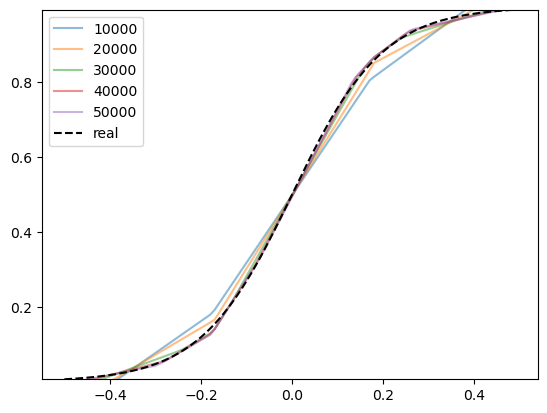

In [3]:
# Определяем функцию нелинейности
relu = lambda x: torch.maximum(x, torch.Tensor([0]))
# Прямой проход
forward = lambda x: (weights_2.t()*relu((weights_1*x) + bias_1)
                      ).sum(axis=-1,keepdims=True) + bias_2
loss = lambda y, y_: ((y-y_)**2).sum(axis=-1)

# # обратный проход
def backward(X, y, y_pred):
    # производная функции потерь по y_pred
    dL = 2*(y_pred-y)
    # значения нейронов скрытого слоя до применения активации
    Ax = (weights_1*X) + bias_1
    # значения нейронов скрытого слоя после применения активации
    A = relu(Ax)
    # производная функции потерь по weight_2
    dW2 = torch.mm(A.t(), dL)
    # производная функции потерь по bias_2
    db2 = dL.sum(axis=0)
    # производная функции потерь по значениям скрытого слоя после активации
    dA = torch.mm(dL, weights_2.t())
    # производная функции потерь по значениям скрытого слоя до активации
    dA[Ax<=0] = 0
    # производная функции потерь по weight_1
    dW = torch.mm(X.t(), dA)
    # производная функции потерь по bias_1
    db = dA.sum(axis=0)
    #print(dW.shape, db.shape, dW2.shape, db2.shape)
    return dW, db, dW2, db2

def optimize(params, grads, lr=0.001):
    # градиентный спуск по всей обучающей выборке
    W1, b1, W2, b2 = params
    W1 -= lr*grads[0]
    W2 -= lr*grads[2]
    b1 -= lr*grads[1]
    b2 -= lr*grads[3]
    return W1, b1, W2, b2

for i in range(50000): # 50 тысяч итераций градиентного спуска == 50 тысяч эпох
  output = forward(tensor_X)
  cur_loss = loss(output, tensor_y)
  grads = backward(tensor_X, tensor_y, output)
  params = [weights_1, bias_1, weights_2, bias_2]
  weights_1, bias_1, weights_2, bias_2 = optimize(params, grads, 1e-4)
  if (i+1)%10000 == 0:
      plt.plot(X, output.numpy(), label=str(i+1), alpha=0.5)
plt.plot(X, y, linestyle='--', c='k', label='real')
plt.legend()
plt.ylim(y.min(), y.max())
print(cur_loss.numpy().mean())

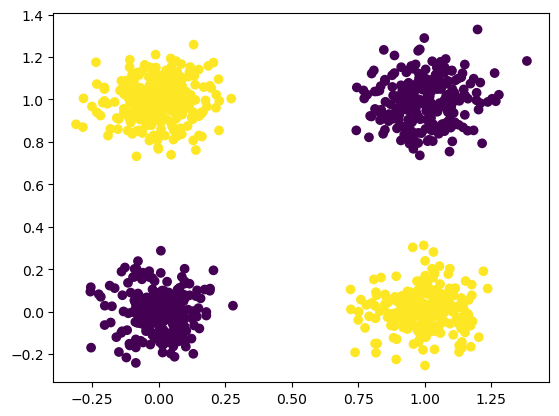

In [4]:
X = np.random.randint(2, size=(1000, 2))

y = (X[:, 0] + X[:, 1]) % 2 # XOR
X = X + np.random.normal(0, scale=0.1, size=X.shape)
#X, y = make_circles(n_samples=1000, noise=0.025)
#X, y = make_moons(n_samples=1000, noise=0.025)
plt.scatter(X[:, 0], X[:, 1], c=y)
####################################################
tensor_X = torch.Tensor(X.reshape(-1, 2))
tensor_y = torch.Tensor(y.reshape(-1, 1))

HIDDEN_SIZE = 32
# Инициализация весов MLP с одним скрытым слоём
weights_1 = ((torch.rand(2, HIDDEN_SIZE)-.5)/10).detach().requires_grad_(True)
bias_1 = torch.zeros(HIDDEN_SIZE, requires_grad=True)

weights_2 = ((torch.rand(HIDDEN_SIZE, 1)-.5)/10).detach().requires_grad_(True)
bias_2 = torch.zeros(1, requires_grad=True)

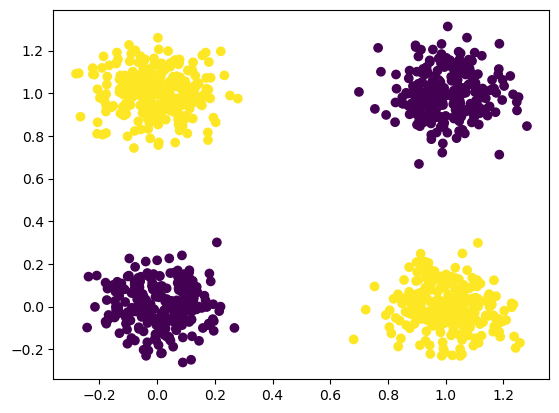

In [5]:
X = np.random.randint(2, size=(1000, 2))

y = (X[:, 0] + X[:, 1]) % 2 # XOR
X = X + np.random.normal(0, scale=0.1, size=X.shape)
#X, y = make_circles(n_samples=1000, noise=0.025)
#X, y = make_moons(n_samples=1000, noise=0.025)
plt.scatter(X[:, 0], X[:, 1], c=y)
####################################################
tensor_X = torch.Tensor(X.reshape(-1, 2))
tensor_y = torch.Tensor(y.reshape(-1, 1))

HIDDEN_SIZE = 32
# Инициализация весов MLP с одним скрытым слоём
weights_1 = ((torch.rand(2, HIDDEN_SIZE)-.5)/10).detach().requires_grad_(True)
bias_1 = torch.zeros(HIDDEN_SIZE, requires_grad=True)

weights_2 = ((torch.rand(HIDDEN_SIZE, 1)-.5)/10).detach().requires_grad_(True)
bias_2 = torch.zeros(1, requires_grad=True)

In [7]:
X_diff = X.max() - X.min()
X_left = X.min() - 0.1 * X_diff
X_right = X.max() + 0.1 * X_diff
grid = np.arange(X_left, X_right, 0.01)
grid_width = grid.size
surface = np.array([[x1, x2] for x1 in grid for x2 in grid])

# Получение предсказаний для сетки
with torch.no_grad():
    Z = forward(torch.Tensor(surface)).detach().numpy()

# Преобразование результатов для отображения
Z = Z.reshape(grid_width, grid_width)
xx = surface[:, 0].reshape(grid_width, grid_width)
yy = surface[:, 1].reshape(grid_width, grid_width)

# Визуализация результатов
plt.contourf(xx, yy, Z, levels=50, cmap='coolwarm', alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.xlim(X_left, X_right)
plt.ylim(X_left, X_right)

RuntimeError: The size of tensor a (32) must match the size of tensor b (2) at non-singleton dimension 1

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

In [ ]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [12, 34, 65]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

In [ ]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

In [ ]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32*32*3, hidden_size*2),
            nn.ReLU(),
            nn.Linear(hidden_size*2, hidden_size*2),
            nn.ReLU(),
            nn.Linear(hidden_size*2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

HIDDEN_SIZE = 20
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#
EPOCHS = 250
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#
EPOCHS = 250
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')


In [ ]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_CNN_AUG.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})

In [ ]:
 for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

In [ ]:
weights = list(model.parameters())[0].detach().numpy()
print(weights.shape)
fig, ax = plt.subplots(1, weights.shape[0], figsize=(3*weights.shape[0], 3))
for i, ω in enumerate(weights):
    ω = ω.reshape(32, 32, 3)
    ω -= np.percentile(ω, 1, axis=[0, 1])
    ω /= np.percentile(ω, 99, axis=[0, 1])
    ω = np.clip(ω, 0, 1)
    ax[i].imshow(ω)